In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install yolov5
!pip install scikit-learn

In [ ]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt



# Importing the Dependencies

In [37]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [38]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import gymnasium as gym
from gym import spaces
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import average_precision_score
from pathlib import Path
from IPython.display import clear_output
import random
from collections import deque
import copy

In [39]:
# Model
model = th.hub.load("ultralytics/yolov5", "yolov5s", pretrained = True)

Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-8 Python-3.10.12 torch-2.8.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# The custom Gym Environment

In [40]:
class ImagePreprocessorEnv(gym.Env):

    def __init__(self, img_dir , yolo_v5_model , steps = 5):
        super().__init__()   

        # Storing the input args
        self.img_dir = img_dir
        self.yolo_v5_model = yolo_v5_model
        self.steps = steps
        self.current_image_index = 0
        self.processed_image = None

        # Loading all image file paths
        self.img_paths = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.observation_space = spaces.Box(
            low=np.array([0.0] * 3), # Brightness Contrast and Sharpness
            high=np.array([1.0] * 3),
            dtype=np.float32
        )

        #  action space 
        self.action_space = spaces.Box(
            low=np.array([-1.0, -1.0, -1.0]), # Tuning the  Brightness, Contrast and Sharpness
            high=np.array([1.0, 1.0, 1.0]),
            dtype=np.float32
        )


    def reset(self):
        self.current_step = 0

        # Select the image each episode
        img_path = self.img_paths[self.current_image_index]
        self.current_image_index = self.current_image_index + 1

        self.intial_image = cv.imread(img_path)
        self.intial_image = cv.cvtColor(self.intial_image, cv.COLOR_BGR2RGB)

        self.processed_image = self.intial_image.copy()
        self.last_conf = self.confidence(self.processed_image)

        obs = self._get_observation()

        return obs
    

    @staticmethod
    def normalize_val(value , min = 0 , max = 255):
        return np.clip((value - min) / (max - min), 0.0, 1.0)
    
    
    def _get_observation(self):

        gray_image = cv.cvtColor(self.processed_image, cv.COLOR_RGB2GRAY)
        
        # Get the observation features 
        brightness = np.mean(gray_image) # mean brightness

        contrast = np.std(gray_image)  # Difference in contrast
        
        sharpness = cv.Laplacian(gray_image, cv.CV_64F).var() # Sharpness using variance of Laplacian 

        # Normalize features
        obs = np.array([
            self.normalize_val(brightness),
            self.normalize_val(contrast, 0 , 128),
            self.normalize_val(sharpness),

        ], dtype=np.float32)

        return obs # Returns a Np array of all the observations 
    

    def confidence(self, image):

        # The result of Yolov5s detection on the passed image
        results = self.yolo_v5_model(image)

        # If None
        if results.pred[0].shape[0] == 0:
            return [0.0]
        
        # print(results.pred)5
        # Return list of confidences of all objects detected by yolo
        return results.pred[0][:, 4].numpy().tolist()
    


    def transform(self, image, action):

        img = Image.fromarray(image)

        # Can changes it from [0.8 , 1.3]
        brightness_factor = 1.0 + action[0] * 0.2
        img = ImageEnhance.Brightness(img).enhance(brightness_factor) # An enhancement factor of 0.0 results in a full black image and an enhancement factor of 1.0 results the same as the original image.

        # Can changes it from [0.8 , 1.3]
        contrast_factor = 1.0 + action[1] * 0.2
        img = ImageEnhance.Contrast(img).enhance(contrast_factor) # An enhancement factor of 0.0 results in a full grey image and an enhancement factor of 1.0 results the same as the original image.

        # Can changes it from [0.5 , 2.5]
        sharp_factor = (action[2] + 1.5) * 1.5
        img = ImageEnhance.Sharpness(img).enhance(sharp_factor) # An enhancement factor of 0.0 results in a blurred image and an enhancement factor of 1.0 results in the same as the original image and a factor > 1.0 results in a sharpened image.

        return np.array(img)
     

    
    def reward_function(self, old_conf, new_conf):

        #Lenght of confidences
        old_count = len(old_conf)
        new_count = len(new_conf)

        # Mean of all confidence vals
        old_avg = np.mean(old_conf) if old_conf else 0
        new_avg = np.mean(new_conf) if new_conf else 0

        # Delta count and conf
        delta_count = new_count - old_count
        delta_conf = new_avg - old_avg

        reward = (1 * delta_count) + (2.5 *delta_conf) + 0.15  # Weighted Rewards to be tweaked 

        # Soft Scaling the rewards 
        reward = np.tanh(reward / 3.0) 

        return reward


    def step(self, action):

        # Unprocessed image's confidence
        old_conf = self.last_conf

        # Apply the transformations
        self.processed_image = self.transform(self.processed_image, action)
        
        # Processed image's confidence
        new_conf = self.confidence(self.processed_image)

        # Calculate reward
        reward = self.reward_function(old_conf, new_conf)

        self.last_conf = new_conf

        obs = self._get_observation()

        # Check if done flag is set
        self.current_step += 1
        done = self.current_step >= self.steps

        # Log info
        info = {
            "old_confidence": old_conf,
            "new_confidence": new_conf,
            "step": self.current_step
        }

        # print(f"The Info Of the current Step is {info} ")

        return obs, reward, done, info

    
    def render(self , image):
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# Actor Critic Network 

In [41]:

class Actor(nn.Module):

    def __init__(self, no_states, no_actions):
        super().__init__()

        
        self.network = nn.Sequential(
            nn.Linear(no_states, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256,no_actions) 
        )

        # O/P activation fn
        self.tanh = nn.Tanh()  

    def forward(self, state):

        out = self.network(state)

        # Applying the activation fn to the outputs
        brightness = self.tanh(out[:, 0:1])   # in [-1, 1]
        contrast = self.tanh(out[:, 1:2])     # in [-1, 1]
        sharpness = self.tanh(out[:, 2:3]) # in [-1, 1]

        # Concatenate the final action vector
        action = th.cat([brightness, contrast, sharpness], dim=1)
        return action
 

class Critic(nn.Module):
    def __init__(self, no_states, no_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(no_states, 256)
        self.fc2 = nn.Linear(256 + no_actions, 256)

        # Q-value output n/w
        self.q_out = nn.Linear(256, 1)

    def forward(self, state, action):
        
        state_out = F.relu(self.fc1(state))

        x = th.cat([state_out, action], dim=1)
        x = F.relu(self.fc2(x))

        q_value = self.q_out(x)
        return q_value

In [42]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transition = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transition)
        return (
            th.FloatTensor(state),
            th.FloatTensor(action),
            th.FloatTensor(reward),
            th.FloatTensor(next_state),
            th.FloatTensor(done),
        )

    def __len__(self):
        return len(self.buffer)

In [43]:
def soft_update(target_net, source_net, tau=0.005):
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)

In [44]:
# CONSTANTS 
GAMMA = 0.99 # Discount Factor
TAU = 0.005 # Soft Update parameter
BATCH_SIZE = 128 # Size of batch for replay buffer
MAX_EPISODES = 1820 # Number of images to train
MAX_STEPS = 5 # Steps per image


# Hyperparameters 
updates_per_step = 2  # do multiple gradient updates per step        
policy_delay = 2          # Update actor once every `policy_delay` critic updates
max_grad_norm = 0.5    # gradient clipping
start_sigma = 0.3       # initial exploration noise
end_sigma = 0.02         # final noise
rolling_window = 100     # smoothing window


In [45]:
img_directory = r"D:\CODE\Atri\Dataset\Train"

# Initializing the Env
env = ImagePreprocessorEnv(img_directory, model)
no_states = env.observation_space.shape[0]
no_actions = env.action_space.shape[0]

# Creating the Actor and Critic Networks
actor = Actor(no_states, no_actions)
critic = Critic(no_states, no_actions)

# Creating Target Actor and Critic
target_actor = copy.deepcopy(actor)
target_critic = copy.deepcopy(critic)

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-5)

replay_buffer = ReplayBuffer(20000)

In [46]:
def add_noise(action, sigma=0.1):
    noise =  np.random.normal(0, sigma, size=action.shape)
    return np.clip(action + noise, -1.0, 1.0)

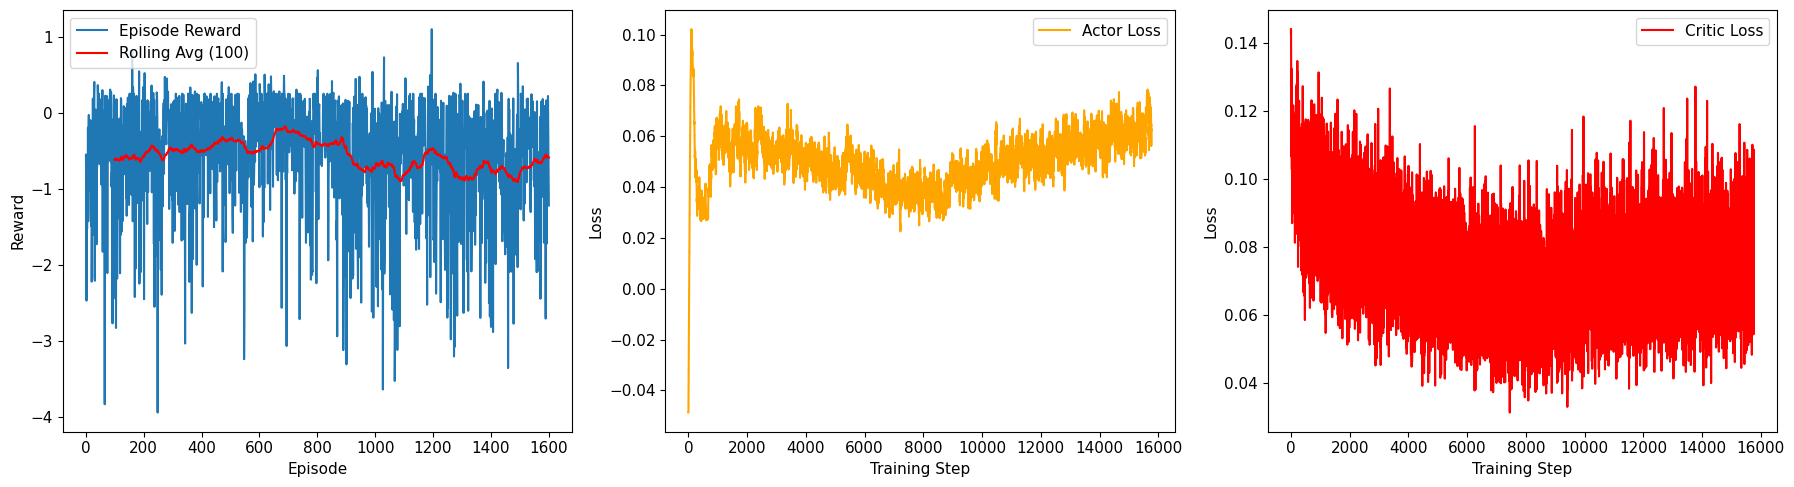

IndexError: list index out of range

In [47]:

# Lists to display graphs while training
episode_rewards_list = []
actor_losses_list = []
critic_losses_list = []

# Training loop
for episode in range(MAX_EPISODES):
    
    # Get the state variables
    state = env.reset()
    episode_reward = 0

    # Decaying noise 
    sigma = end_sigma + (start_sigma - end_sigma) * np.exp(-4 * episode / MAX_EPISODES)

    print(f"\n=== Episode {episode+1}/{MAX_EPISODES} | Sigma: {sigma:.3f} ===")

    update_count = 0 # Update count of critic 

    for step in range(MAX_STEPS):
        
        # Get action for current state
        with th.no_grad():
            state_tensor = th.FloatTensor(state).unsqueeze(0)
            action = actor(state_tensor).cpu().numpy()[0]

        action = add_noise(action, sigma) # We add noise to allow the agent to explore rather exploit 

        next_state, reward, done, info = env.step(action)

        # print(f"Reward: {reward} and Done: {done}")

        replay_buffer.add(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward
        

        if len(replay_buffer) > BATCH_SIZE:

            for _ in range(updates_per_step):  #  multiple updates per step

                # Sample from replay buffer
                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                states = th.FloatTensor(states)
                actions = th.FloatTensor(actions)
                rewards = th.FloatTensor(rewards).unsqueeze(1)
                next_states = th.FloatTensor(next_states)
                dones = th.FloatTensor(dones).unsqueeze(1)

                # Critic Loss
                with th.no_grad():
                    next_actions = target_actor(next_states)
                    target_Q = target_critic(next_states, next_actions)
                    target_Q = rewards + GAMMA * (1 - dones) * target_Q

                current_Q = critic(states, actions)
                critic_loss = nn.MSELoss()(current_Q, target_Q)

                critic_optimizer.zero_grad()
                critic_loss.backward()
                th.nn.utils.clip_grad_norm_(critic.parameters(), max_grad_norm) # Max gradient normalization
                critic_optimizer.step()

                # Delayed actor update
                if update_count % policy_delay == 0:
                    actor_loss = -critic(states, actor(states)).mean()

                    actor_optimizer.zero_grad()
                    actor_loss.backward()
                    th.nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
                    actor_optimizer.step()

                    # Soft update targets (only after actor update)
                    soft_update(actor, target_actor, TAU)
                    soft_update(critic, target_critic, TAU)

                # Store losses
                actor_losses_list.append(actor_loss.item() )
                critic_losses_list.append(critic_loss.item())

                update_count += 1

        if done:
            break

    episode_rewards_list.append(episode_reward)


    # Live Plot 
    clear_output(wait=True)
    plt.figure(figsize=(18,5))

    # Rewards
    plt.subplot(1, 3, 1)
    plt.plot(episode_rewards_list, label='Episode Reward')
    if len(episode_rewards_list) >= rolling_window:
        rewards_rolling = pd.Series(episode_rewards_list).rolling(rolling_window).mean()
        plt.plot(rewards_rolling, label=f'Rolling Avg ({rolling_window})', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()


    # Actor Loss
    plt.subplot(1, 3, 2)
    plt.plot(actor_losses_list, label='Actor Loss', color='orange')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    # Critic Loss
    plt.subplot(1, 3, 3)
    plt.plot(critic_losses_list, label='Critic Loss', color='red')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# # Save actor and critic
# th.save(actor.state_dict(), "actor.pth")
# th.save(critic.state_dict(), "critic.pth")
# print("Actor and Critic saved.")

Actor and Critic saved.


In [ ]:
# Create actor for eval
actor = Actor(no_states, no_actions)

# Load weights
actor.load_state_dict(th.load("actorV1.pth"))

actor.eval()



Models loaded for evaluation.


Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-8-8 Python-3.10.12 torch-2.8.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Processing class: Bus
D:\CODE\Atri\Dataset\Test\Bus\2015_01884.png
2015_01884.png | Confidences: Original=[    0.94118     0.87134     0.81642      0.7498     0.64116     0.62953     0.46476     0.43982     0.37297     0.29809     0.25589] | Processed=[    0.94093     0.87137     0.81827     0.76551     0.65272     0.64062     0.46941     0.45627     0.36906     0.30542]
D:\CODE\Atri\Dataset\Test\Bus\2015_01900.jpg
2015_01900.jpg | Confidences: Original=[    0.92085] | Processed=[    0.91994]
D:\CODE\Atri\Dataset\Test\Bus\2015_01904.jpg
2015_01904.jpg | Confidences: Original=[    0.81201] | Processed=[    0.80831     0.26019]
D:\CODE\Atri\Dataset\Test\Bus\2015_01907.jpg
2015_01907.jpg | Confidences: Original=[    0.91703     0.79324     0.39986] | Processed=[    0.91308     0.80109     0.41684]
D:\CODE\Atri\Dataset\Test\Bus\2015_01916.jpg
2015_01916.jpg | Confidences: Original=[    0.72078     0.67926     0.62901     0.59644     0.34855] | Processed=[    0.71387     0.71187     0.62202

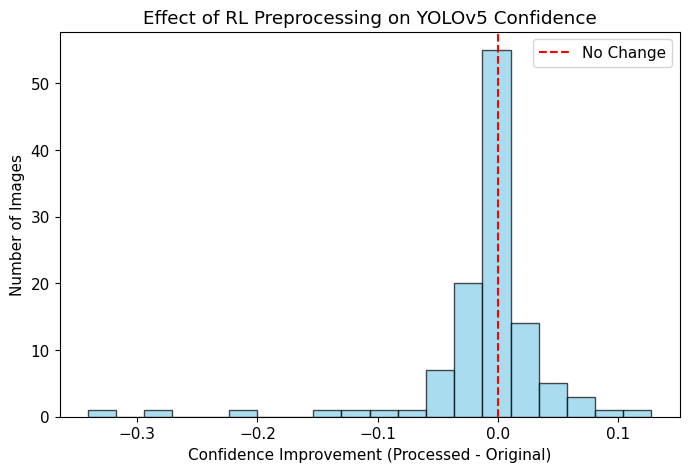

In [ ]:


model = th.hub.load("ultralytics/yolov5", "yolov5s", pretrained = True)
model.eval()
test_dir = r"D:\CODE\Atri\Dataset\Test"

env_eval = ImagePreprocessorEnv(test_dir, model, steps=MAX_STEPS)

# Lists for Validation Graphs
all_conf_diffs = []
scores_orig = []
scores_proc = []
y_true = []

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)

    # Create a new environment for each class's images
    env_eval = ImagePreprocessorEnv(class_path, model, steps=MAX_STEPS)

    # For Each test image 
    for fname in os.listdir(class_path):

        img_path = os.path.join(class_path, fname)
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Prepare state
        state  =  env_eval.reset()
        state_tensor = th.FloatTensor(state).unsqueeze(0)

        # Actor predicts action
        with th.no_grad():
            action = actor(state_tensor).cpu().numpy()[0]

        # Apply transformation using env
        img_proc = env_eval.transform(img_rgb, action)

        # Run YOLO on both
        results_orig = model(img_rgb)
        results_proc = model(img_proc)  

        # Extract confidences and labels
        pred_orig = results_orig.pred[0].cpu().numpy()
        pred_proc = results_proc.pred[0].cpu().numpy()

        confs_orig = pred_orig[:, 4] if pred_orig.size > 0 else []
        confs_proc = pred_proc[:, 4] if pred_proc.size > 0 else []

        mean_orig = np.mean(confs_orig) if len(confs_orig) > 0 else 0
        mean_proc = np.mean(confs_proc) if len(confs_proc) > 0 else 0
        all_conf_diffs.append(mean_proc - mean_orig)

# Plot histogram of differences
plt.figure(figsize=(8, 5))
plt.hist(all_conf_diffs, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="No Change")
plt.xlabel("Confidence Improvement (Processed - Original)")
plt.ylabel("Number of Images")
plt.title("Effect of RL Preprocessing on YOLOv5 Confidence")
plt.legend()
plt.show()

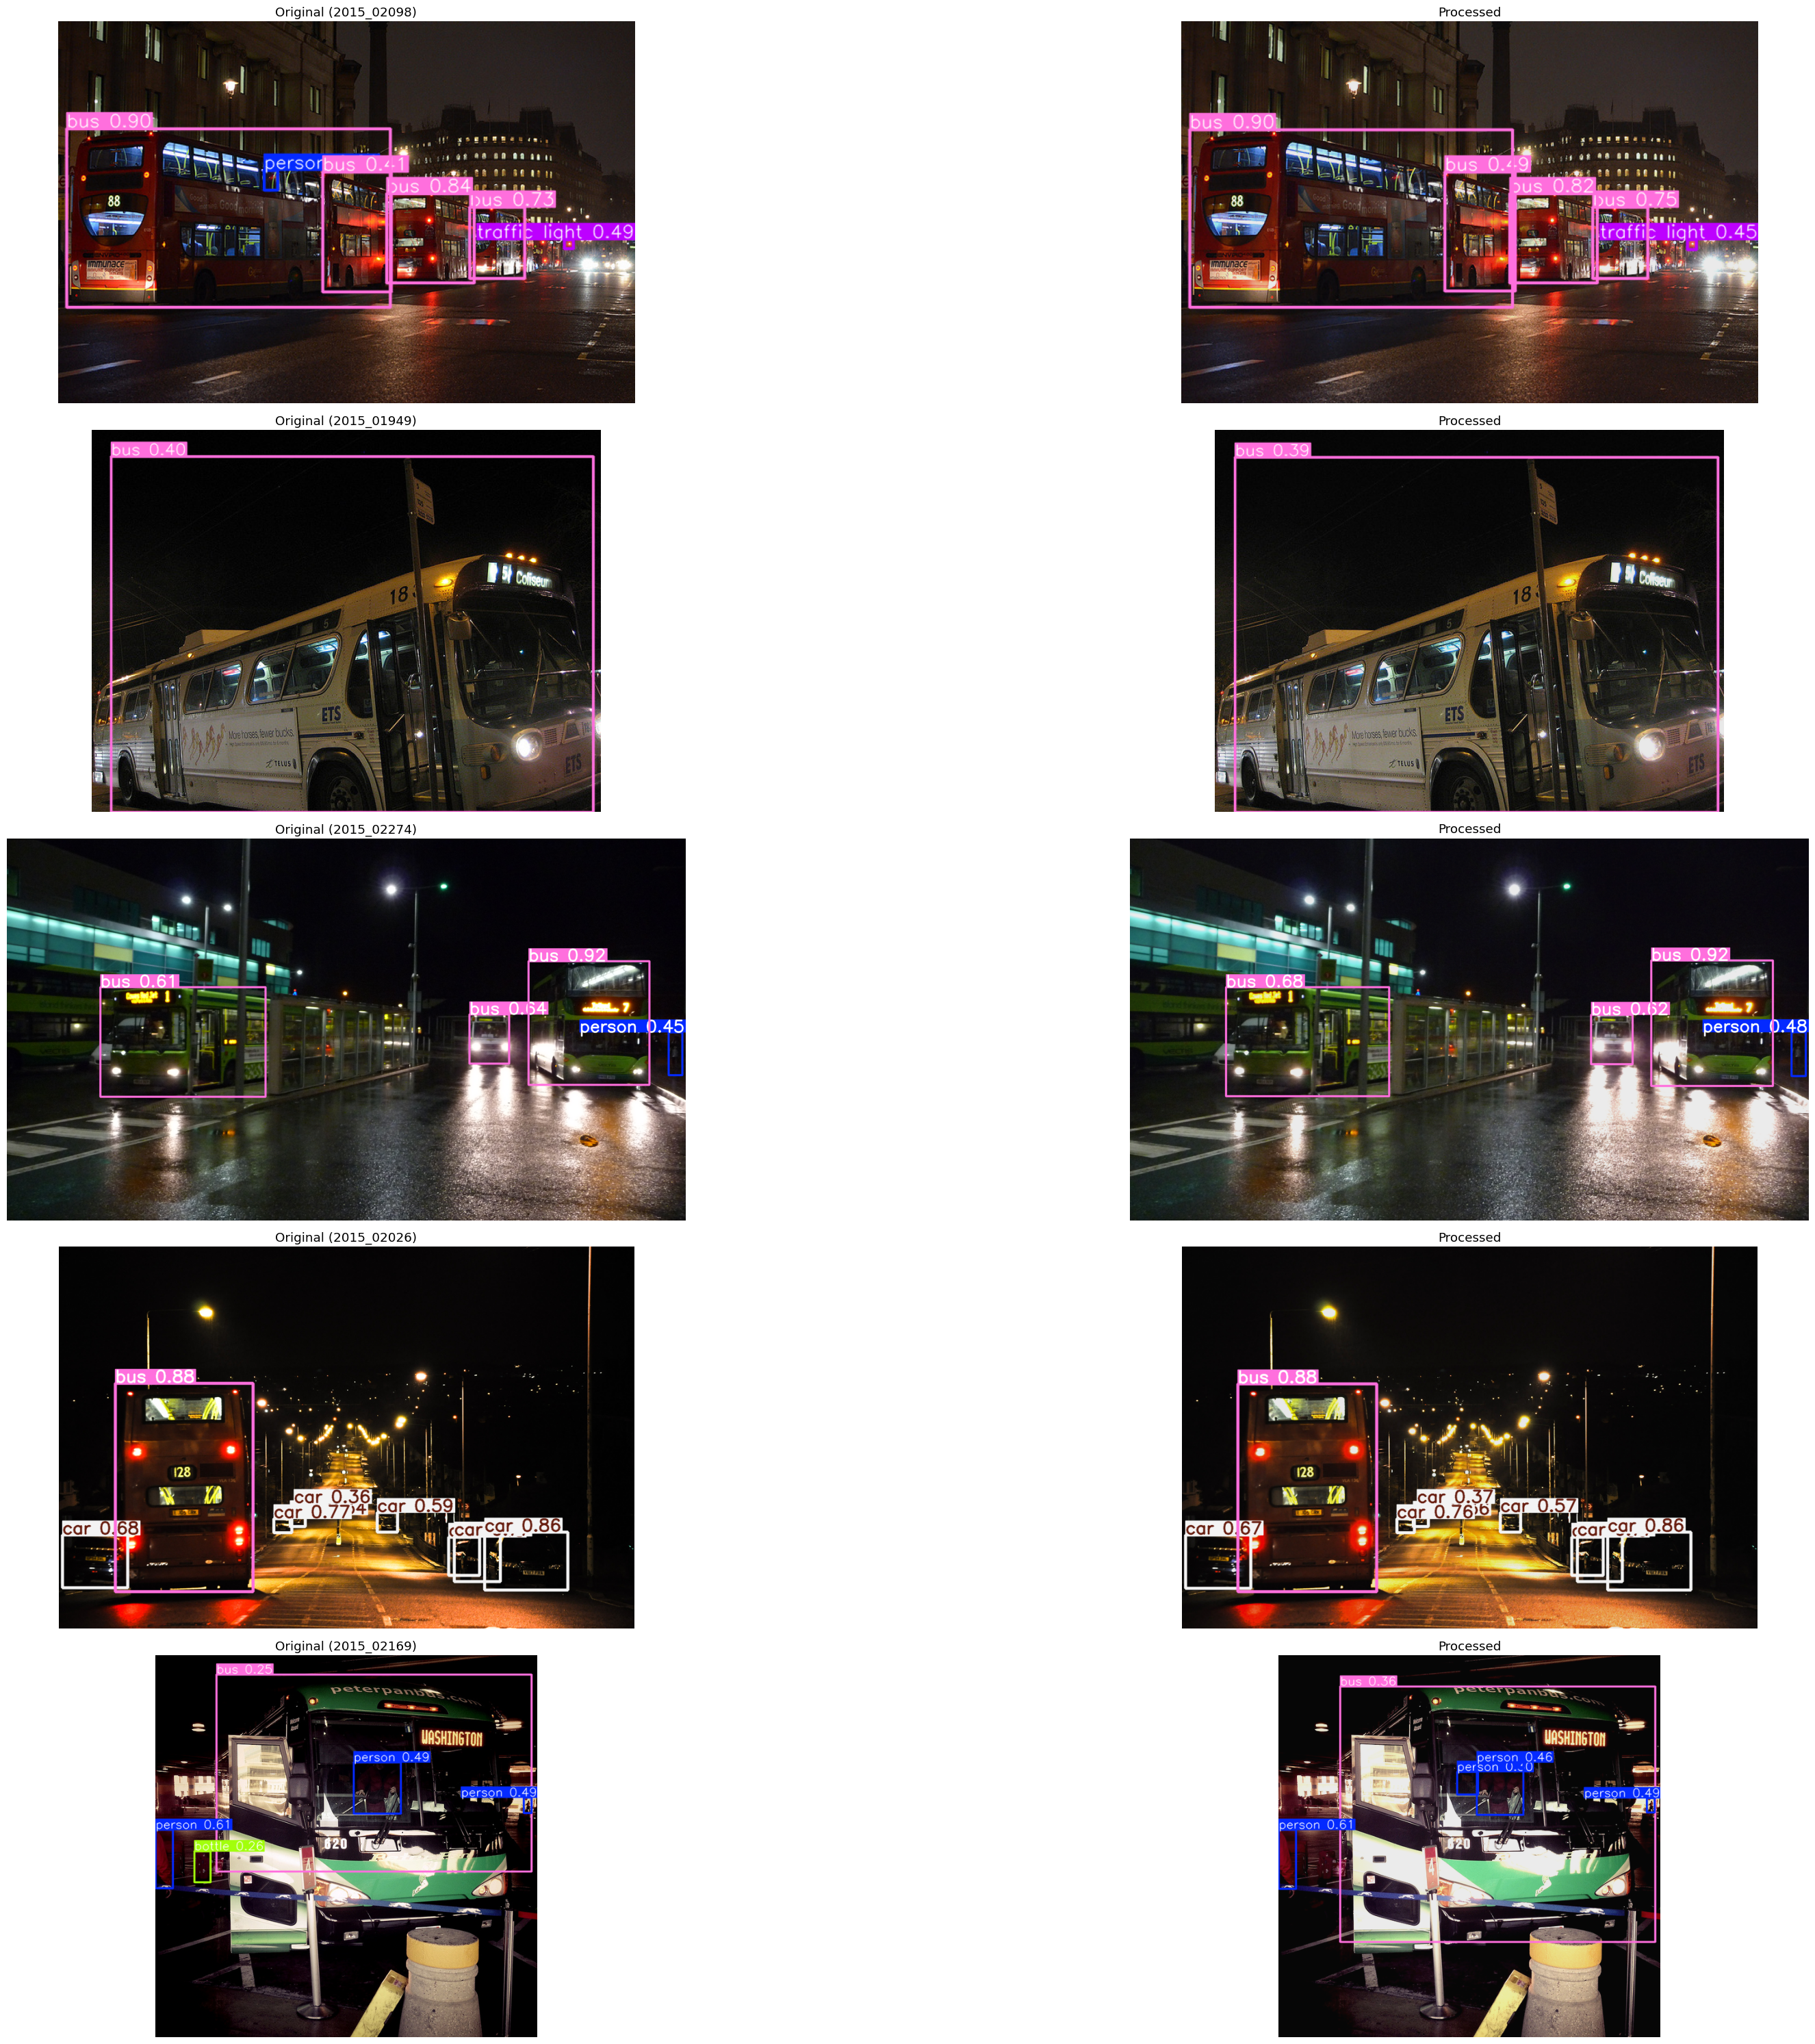

In [ ]:
import random

# Collect all test images
all_images = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg')):
                all_images.append(os.path.join(class_path, fname))

# Pick 5 random images
sample_paths = random.sample(all_images, 5)

plt.figure(figsize=(40, 30))

for i, img_path in enumerate(sample_paths):
    class_path = os.path.dirname(img_path)
    env_eval = ImagePreprocessorEnv(class_path, model, steps=MAX_STEPS)

    # Load image
    img = cv.imread(img_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # RL Agent processing
    state = env_eval.reset()
    state_tensor = th.FloatTensor(state).unsqueeze(0)
    with th.no_grad():
        action = actor(state_tensor).cpu().numpy()[0]
    img_proc = env_eval.transform(img_rgb, action)

    # Run YOLO 
    results_orig = model(img_rgb)
    results_proc = model(img_proc)

    # Annotated images
    orig_annot = np.squeeze(results_orig.render())
    proc_annot = np.squeeze(results_proc.render())

    # Grid plotting
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(orig_annot)
    plt.axis("off")
    plt.title(f"Original ({Path(img_path).stem})")

    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(proc_annot)
    plt.axis("off")
    plt.title("Processed")

plt.tight_layout()
plt.show()
